In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from sklearn.inspection import permutation_importance
import seaborn as sns
import xgboost as xgb
import rfpimp
from sklearn.metrics import accuracy_score, balanced_accuracy_score
import shap

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

# pour afficher les graphiques de shap dans le notebook
shap.initjs()

/home/aleon/miniconda3/envs/interpretation_ml/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
features = ['bathrooms','bedrooms','price','longitude','latitude']
df_train = pd.read_json("data/train.json")
X = df_train[features]
y = df_train['interest_level']
y = y.replace('low',1)
y = y.replace('medium',2)
y = y.replace('high',3)

In [3]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

In [4]:
rf_model = RandomForestClassifier(
         n_estimators=100,
         min_samples_leaf=1,
         n_jobs=-1,
         oob_score=True)
rf_model.fit(X_train, y_train)
pred_train = pd.Series(rf_model.predict(X_train))
print(f"score sur l'ens de train {accuracy_score(pred_train, y_train)}")
pred_val = pd.Series(rf_model.predict(X_val))
print(f"score sur l'ens de test {accuracy_score(pred_val, y_val)}")

score sur l'ens de train 0.9248147588084077
score sur l'ens de test 0.6954012402529625


# SHAP
https://github.com/slundberg/shap/

On travaille sur un sous-échantillon des données pour que les calculs soient plus rapides.

In [5]:
X_train_sample = X_train.sample(1000)
X_val_sample = X_val.sample(1000)
explainer = shap.TreeExplainer(rf_model)
shap_values_train = explainer.shap_values(X_train_sample.values)
shap_values_val = explainer.shap_values(X_val_sample.values)

## Valeurs moyennes
#### Donnnées d'entraînement

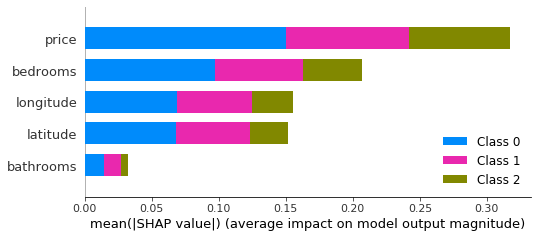

In [6]:
shap.summary_plot(shap_values_train, X_train_sample, plot_type="bar")

#### Données de test

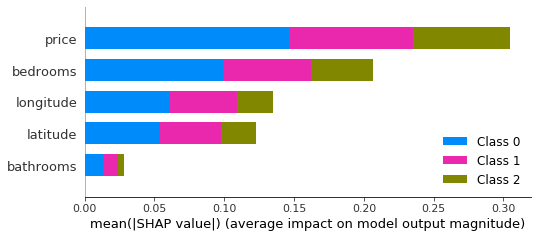

In [7]:
shap.summary_plot(shap_values_val, X_val_sample, plot_type="bar")

In [8]:
# pour pouvoir utiliser les indexation avec Pandas
shap_values_train_ = [pd.DataFrame(shap_values_train[i], index=X_train_sample.index) for i in [0,1,2]]
shap_values_val_ = [pd.DataFrame(shap_values_val[i], index=X_val_sample.index) for i in [0,1,2]]

__Pour les graphiques suivants "summary_plot" (1 graphique par classe) :__

Un point = une donnée. Les valeurs shap (abscisse) sont représentées pour chaque variable (ordonnée), pour chaque donnée. La couleur représente la valeur de la variable. Des "épaisseures" plus importantes (par exemple pour la variable bathrooms en abscisse=0) permettent de représenter une densité de points plus importante.

Remarque : dans le cas où on a uniquement 2 classes, il suffit d'afficher un graphique.

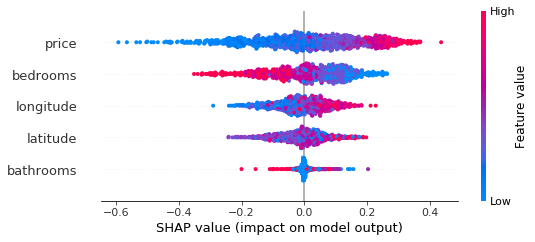

In [9]:
shap.summary_plot(shap_values_val[0], X_val_sample)

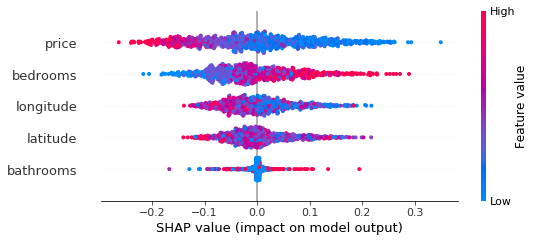

In [10]:
shap.summary_plot(shap_values_val[1], X_val_sample)

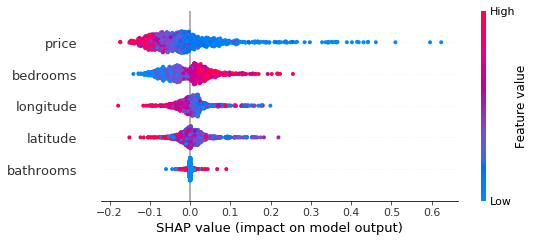

In [11]:
shap.summary_plot(shap_values_val[2], X_val_sample)

## Pour UNE donnée : 
On peut voir les influences de chaque variable sur la prédiction.

In [12]:
def shap_multiclass(idx, data='train'):
    if data=='train':
        y = y_train
        X = X_train_sample
        shap_values = shap_values_train
    elif data=='val':
        y = y_val
        X = X_val_sample
        shap_values = shap_values_val
    #idx = X.index[idx]
    print (idx)
    print ("y réel : "+str(y.iloc[idx]))
    print ("y prédit : "+str(rf_model.predict(X.iloc[idx, :].values.reshape(1, -1))))
    for i in [0,1,2]:
        print (f'classe {i}')
        display(shap.force_plot(explainer.expected_value[i], shap_values[i][idx, :], X.iloc[idx, :]))

In [13]:
shap_multiclass(50,'train')

50
y réel : 1
y prédit : [1]
classe 0


classe 1


classe 2


In [14]:
shap_multiclass(20,'val')

20
y réel : 1
y prédit : [1]
classe 0


classe 1


classe 2


In [15]:
idx = 20
rf_model.predict_proba(X_val_sample.iloc[idx, :].values.reshape(1, -1))[0][0]

0.97

Dans le cas multi-class, on peut afficher les informations sur les différentes classes sur un même graphique, pour UNE donnée :

In [16]:
def class_labels(row_index):
    def pred(c):
        return rf_model.predict_proba(X_val_sample.iloc[row_index, :].values.reshape(1, -1))[0][c]
    return [f'Class {i} ({pred(i).round(2):.2f})' for i in range(3)]

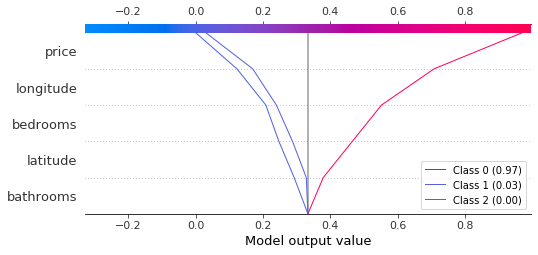

In [17]:
idx = 20
r = shap.multioutput_decision_plot(list(explainer.expected_value), shap_values_val, row_index=idx,
                               feature_names = features,
                               legend_labels=class_labels(idx),
                               legend_location='lower right',
                                return_objects=True
                              )

#### Explications du multiouput_decision_plot :
La *model output value* est cette fois la valeur moyenne des output values pour les différentes classes, et où les valeurs SHAP sont décalées afin de correctement reproduire le score de sortie du modèle. On peut ainsi facilement comparer les effets des variables sur les prédictions des différentes classes.

Si on affiche uniquement pour UNE classe (pour la même donnée) on obtient : 

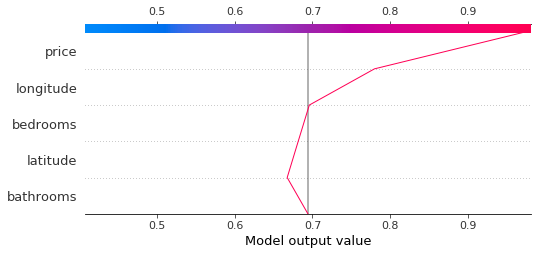

In [18]:
shap.decision_plot(explainer.expected_value[0], shap_values_val[0][idx, :], features, feature_order=r.feature_idx)

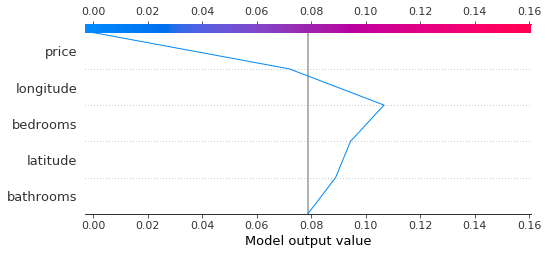

In [19]:
shap.decision_plot(explainer.expected_value[2], shap_values_val[2][idx, :], features, feature_order=r.feature_idx)

### Affichage pour plusieurs donnnées (mais une seule classe, ici la classe 0) :

In [21]:
X_val_sample100 = X_val.sample(500)
shap_values_val100 = explainer.shap_values(X_val_sample100.values)
shap_values_val100_ = [pd.DataFrame(shap_values_val100[i], index=X_val_sample100.index) for i in [0,1,2]]

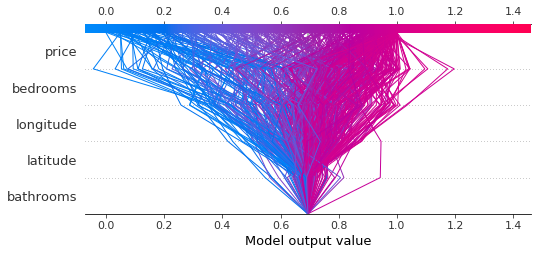

In [22]:
shap.decision_plot(explainer.expected_value[0], shap_values_val100[0],
                  feature_names = features)

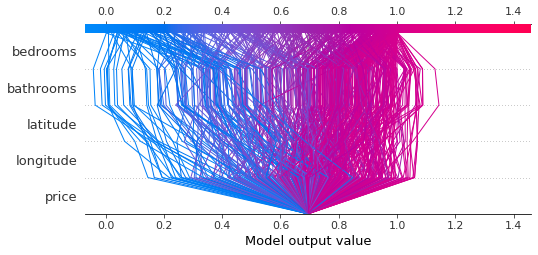

In [23]:
# ordonne les features de manière à regrouper autant que possible les données semblables
r = shap.decision_plot(explainer.expected_value[0], shap_values_val100[0], 
                  feature_names = features, feature_order='hclust', return_objects=True)

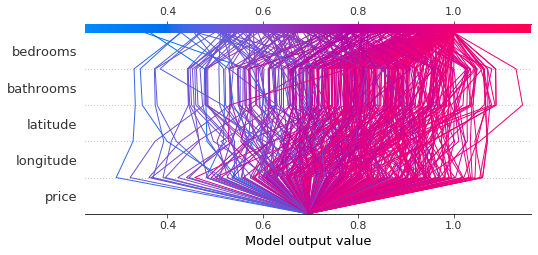

In [24]:
# données pour lesquelles la classe prédite est la classe 1
# utiliser return_objects=True permet de récupérer l'objet pour ensuite utiliser le même ordonnancement des features
y_pred = rf_model.predict(X_val_sample100)
idx = X_val_sample100[y_pred==1].index
shap.decision_plot(explainer.expected_value[0], shap_values_val100_[0].loc[idx, :].values,
                  feature_names = features, feature_order=r.feature_idx)

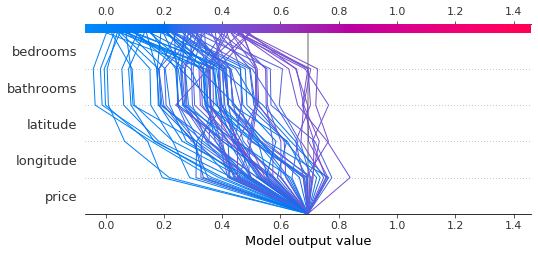

In [25]:
# données pour lesquelles la classe prédite est la classe 2
# utiliser feature_order=r.feature_idx permet d'utiliser le même ordonnancement des features que précédemment
y_pred = rf_model.predict(X_val_sample100)
idx = X_val_sample100[y_pred==2].index
shap.decision_plot(explainer.expected_value[0], shap_values_val100_[0].loc[idx, :].values,
                  feature_names = features, feature_order=r.feature_idx)

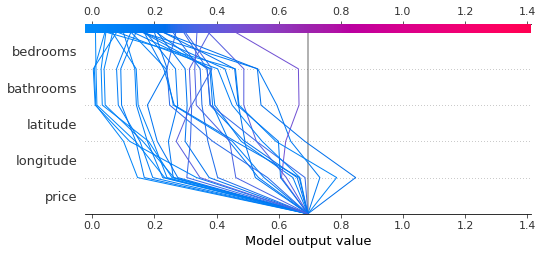

In [26]:
# données pour lesquelles la classe prédite est la classe 3
y_pred = rf_model.predict(X_val_sample100)
idx = X_val_sample100[y_pred==3].index
shap.decision_plot(explainer.expected_value[0], shap_values_val100_[0].loc[idx, :].values,
                  feature_names = features, feature_order=r.feature_idx)

Si on a trop de données, l'idéal serait de prendre un sous-ensemble des données ; par exemple prendre des exemples représentatifs grâce à du clustering sur les valeurs shap des variables.

## Affichage pour plusieurs données.
Rappel : affichage pour une donnée (pour une classe) :

In [27]:
idx = 10
shap.force_plot(explainer.expected_value[0], shap_values_val[0][idx, :], X_val_sample.iloc[idx, :])

On fait ce graphique pour chaque donnée, on les pivote, et on obtient un force_plot général (on peut changer l'ordre dans lequel sont classées les données avec la boite déroulante du haut, et les valeurs affichées avec la boite déroulante de gauche)

In [28]:
shap.force_plot(explainer.expected_value[0], shap_values_val[0], X_val_sample)

In [29]:
# pour un échantillon des données :
shap.force_plot(explainer.expected_value[0], shap_values_val100[0], X_val_sample100)

On peut également s'intéresser spécifiquement à une variable : chaque point représente une donnée, en abscisse on a la valeur de la variable, en ordonnée la valeur shap de la variable, et en couleur on peut afficher les valeurs d'une autre variable pour explorer les dépendences (de base, seconde avriable choisie est celle qui apporte sépare le mieux les points,  mais on peut la choisir) :

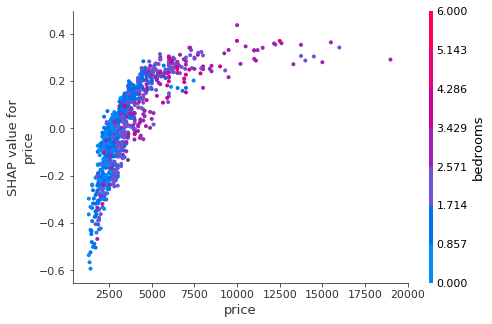

In [30]:
shap.dependence_plot("price", shap_values_val[0], X_val_sample, xmax=20000)

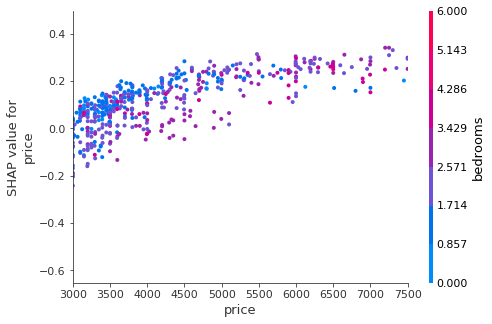

In [31]:
shap.dependence_plot("price", shap_values_val[0], X_val_sample, xmax = 7500, xmin=3000)

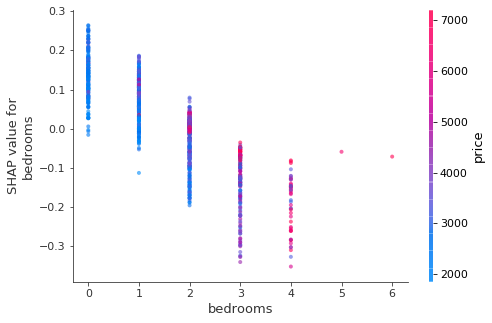

In [32]:
shap.dependence_plot("bedrooms", shap_values_val[0], X_val_sample, alpha=0.6)

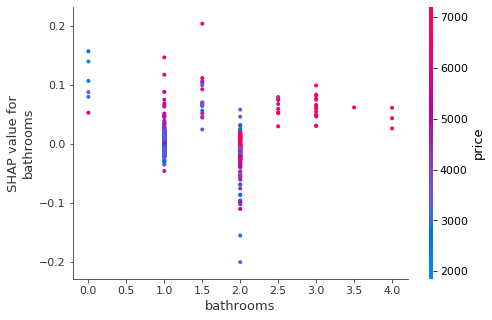

In [33]:
shap.dependence_plot("bathrooms", shap_values_val[0], X_val_sample)

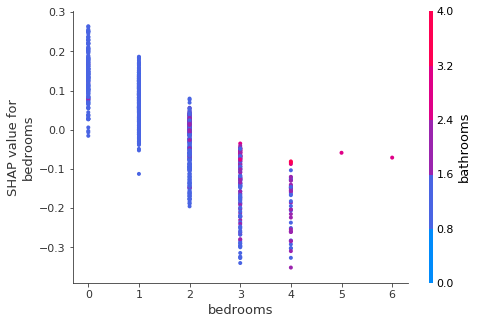

In [34]:
shap.dependence_plot("bedrooms", shap_values_val[0], X_val_sample, interaction_index='bathrooms')

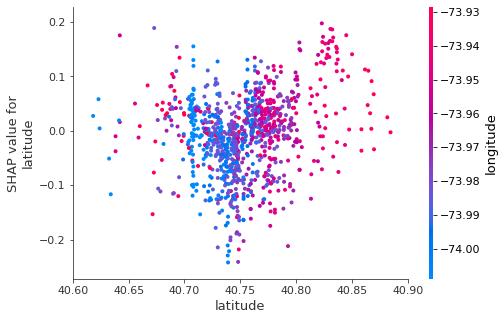

In [35]:
shap.dependence_plot("latitude", shap_values_val[0], X_val_sample, interaction_index='longitude', xmin=40.6, xmax=40.9)

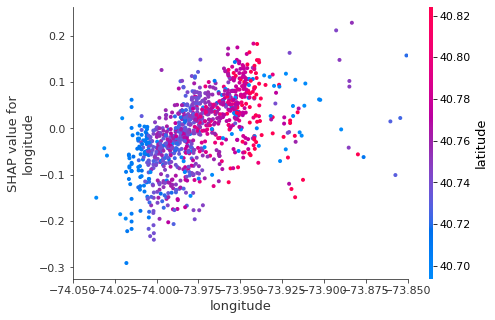

In [36]:
shap.dependence_plot("longitude", shap_values_val[0], X_val_sample, interaction_index='latitude', xmax=-73.85, xmin=-74.05)

### Exploration plus poussée :
De la même manière que pour l'analyse des données, on peut continuer l'exploration... par exemple en regardant les graphiques pour une sélection des données.

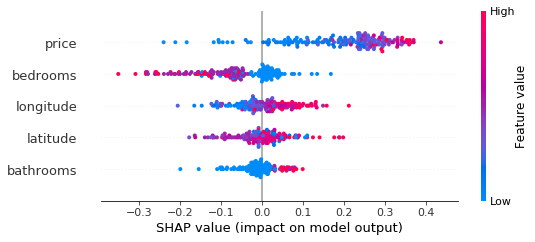

In [37]:
idx = X_val_sample[X_val_sample['bathrooms']>=2].index
shap.summary_plot(shap_values_val_[0].loc[idx, :].values, X_val_sample.loc[idx,:])

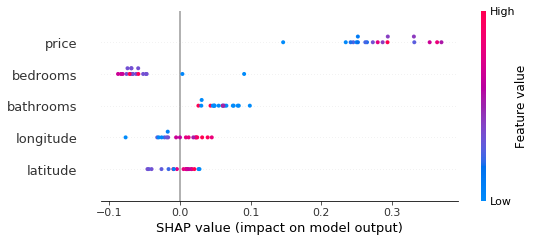

In [38]:
idx = X_val_sample[X_val_sample['bathrooms']>=3].index
shap.summary_plot(shap_values_val_[0].loc[idx, :].values, X_val_sample.loc[idx,:])

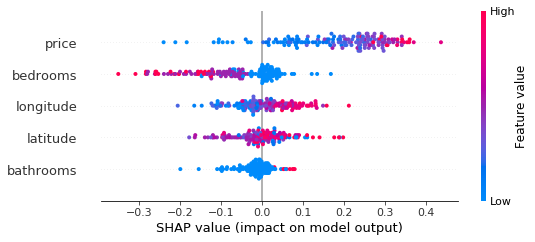

In [39]:
idx = X_val_sample[X_val_sample['bathrooms']<3][X_val_sample['bathrooms']>=2].index
shap.summary_plot(shap_values_val_[0].loc[idx, :].values, X_val_sample.loc[idx,:])

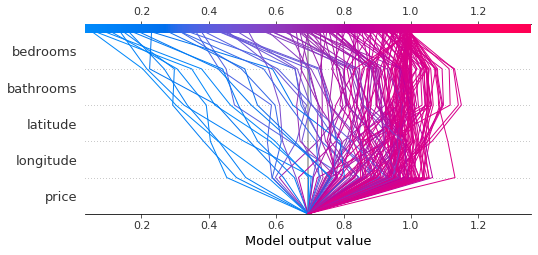

In [40]:
idx = X_val_sample[X_val_sample['bathrooms']<3][X_val_sample['bathrooms']>=2].index
shap.decision_plot(explainer.expected_value[0], shap_values_val_[0].loc[idx, :].values,
                  feature_names = features, feature_order='hclust')

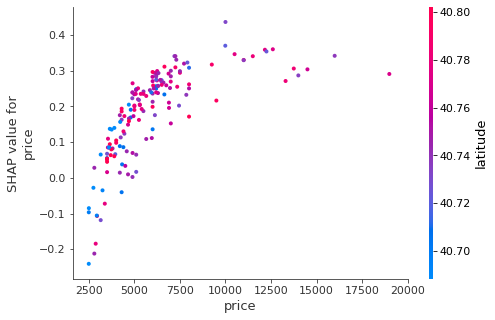

In [41]:
shap.dependence_plot("price", shap_values_val_[0].loc[idx, :].values, X_val_sample.loc[idx,:], xmax=20000)